In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from itertools import combinations
import seaborn as sns
import sys
from src.utils import get_config

config = get_config()
sys.path.append(config["neuroginius"])
from neuroginius.plotting import plot_matrix
from neuroginius.atlas import Atlas

In [2]:
data_dir = Path(config["data_dir"])
mat_file = data_dir / "mean_tangent_patterns.joblib"
perm_mat_file = data_dir / "mean_tangent_perm_patterns.joblib"

with open(mat_file, 'rb') as f:
    haufe_matrices = joblib.load(f)

with open(perm_mat_file, 'rb') as f:
    perm_haufe_matrices = joblib.load(f)
    

In [3]:
conn_measure = joblib.load(config["conn_object"])
diff_matrices = {}
ambient_diff_matrices = {}
null_diff_matrices = {}

#step 1: creation of class differences matrices
classes = ['stable', 'slow', 'steep']

ambient_haufe_matrices = conn_measure.inverse_transform(haufe_matrices / 1e4)

for class1, class2 in combinations(classes, 2):
    print(f"Calculating difference for classes: {class2} - {class1}")
    i = classes.index(class1)
    j = classes.index(class2)

    mat1 = haufe_matrices[i]
    mat2 = haufe_matrices[j]
    
    # Calculate the difference matrix
    diff_matrices[class2, class1] = mat2 - mat1
    
    ambient_mat1 = ambient_haufe_matrices[i]
    ambient_mat2 = ambient_haufe_matrices[j]

    ambient_diff_matrices[class2, class1] = ambient_mat2 - ambient_mat1    


    tmp_null_diff = []
    n_perm = perm_haufe_matrices.shape[0]
    for iter in range(n_perm):
        perm_mat1 = perm_haufe_matrices[iter, i]
        perm_mat2 = perm_haufe_matrices[iter, j]
        
        tmp_null_diff.append(perm_mat2 - perm_mat1)
    
    null_diff_matrices[class2, class1] = np.array(tmp_null_diff)

    


Calculating difference for classes: slow - stable
Calculating difference for classes: steep - stable
Calculating difference for classes: steep - slow


In [4]:
null_diff_matrices['slow', 'stable'].shape

(5000, 200, 200)

In [5]:
def nonparametric_p_value(empirical_matrix, null_matrices, alternative='two-sided'):
    """
    Calculate the p-value for the empirical matrix against the null distribution.
    
    Parameters:
    - empirical_matrix: The observed difference matrix.
    - null_matrix: The null distribution of differences.
    - alternative: 'two-sided', 'greater', or 'less'.
    
    Returns:
    - p-value as a numpy array.
    """
    if alternative == 'two-sided':
        # eps = 1e-4
        # pvalue = (np.sum(np.abs(null_matrices) >= np.abs(empirical_matrix), axis=0)) / (null_matrices.shape[0]) + eps
        # return np.where(pvalue > 1, 1, pvalue)  # Ensure p-values are capped at 1
        return (1 + np.sum(np.abs(null_matrices) >= np.abs(empirical_matrix), axis=0)) / (1 + null_matrices.shape[0])
    elif alternative == 'greater':
        print('to modify')
        return np.mean(null_matrices >= empirical_matrix, axis=0)
    elif alternative == 'less':
        print('to modify')
        return np.mean(null_matrices <= empirical_matrix, axis=0)
    else:
        raise ValueError("Alternative must be 'two-sided', 'greater', or 'less'.")

Calculating p-values for classes: slow - stable
Calculating p-values for classes: steep - stable
Calculating p-values for classes: steep - slow


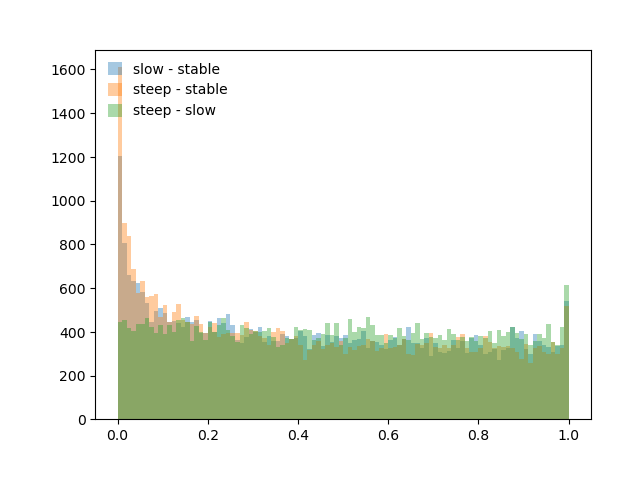

AttributeError: Rectangle.set() got an unexpected keyword argument 'kde'

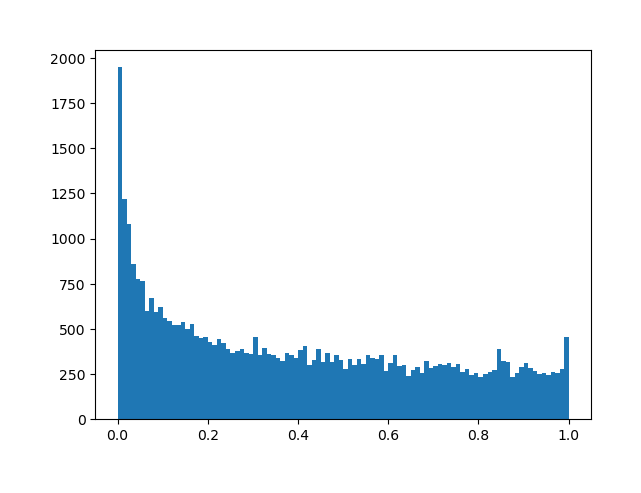

In [39]:
corrected_null_distribution = np.array([mat for mat in null_diff_matrices.values()]).max(axis=0)
p_values = {}
corrected_p_values = {}
for class1, class2 in combinations(classes, 2):
    print(f"Calculating p-values for classes: {class2} - {class1}")
    diff_matrix = diff_matrices[class2, class1]
    null_diff_matrix = null_diff_matrices[class2, class1]
    
    # Calculate p-values
    p_values[class2, class1] = nonparametric_p_value(diff_matrix, null_diff_matrix, alternative='two-sided')
    corrected_p_values[class2, class1] = nonparametric_p_value(diff_matrix, corrected_null_distribution, alternative='two-sided')
    plt.hist(
        p_values[class2, class1].flatten(),
        bins=100,
        alpha=0.4,
        label=f"{class2} - {class1}"
    )
plt.legend()
plt.show()
for cor_ps in corrected_p_values.values():
    plt.hist(cor_ps.flatten(), bins=100, kde=True)
plt.show()

In [7]:
diff_matrices.keys()

dict_keys([('slow', 'stable'), ('steep', 'stable'), ('steep', 'slow')])

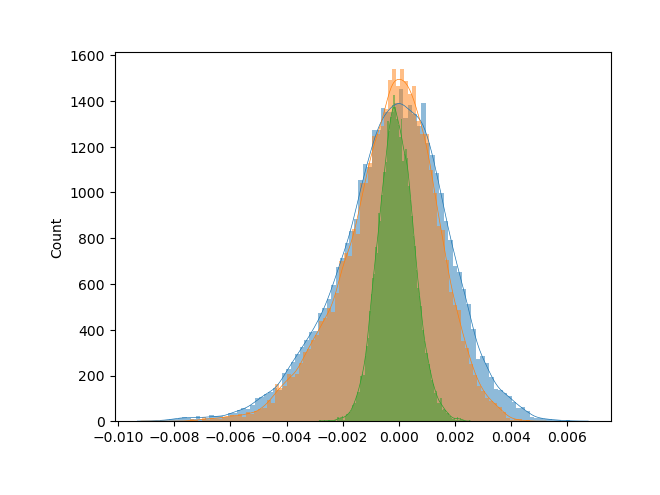

In [8]:
for combination in diff_matrices.keys():
    sns.histplot(ambient_diff_matrices[combination].flatten(), bins=100, kde=True)

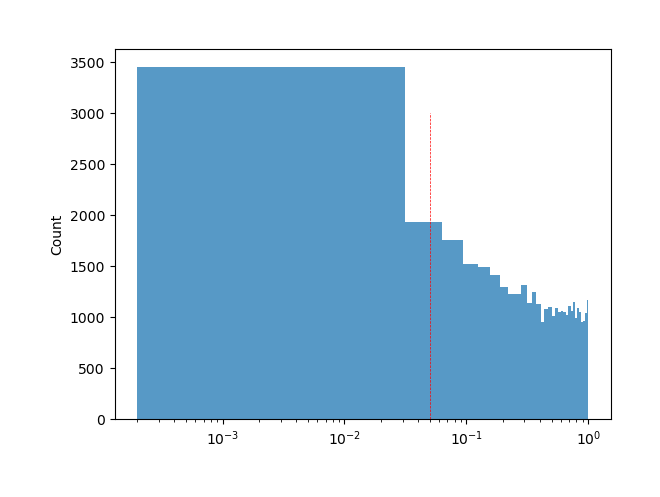

In [9]:
sns.histplot(p_values['steep', 'stable'].ravel())
plt.xscale('log')
plt.vlines(0.05, 0, 3000, color='red', linestyle='--')

In [10]:
from matplotlib.ticker import FixedLocator        

def set_network_ticks(axes, atlas):
    networks = np.array(atlas.macro_labels)
    sort_index = np.argsort(networks)
    n_regions = len(networks)
    ticks = []
    lbls = []
    prev_label = None
    for i, label in enumerate(networks[sort_index]):
        if label != prev_label:
            ticks.append(i)
            lbls.append(label)
            prev_label = label
            axes.hlines(i, 0, n_regions, colors="black", linestyles="dotted")
            axes.vlines(i, 0, n_regions, colors="black", linestyles="dotted")

    ticks.append(i + 1)

    axes.yaxis.set_minor_locator(FixedLocator(ticks))
    axes.yaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
    axes.xaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
    axes.set_yticklabels(lbls, rotation=0, fontsize=12)
    axes.set_xticklabels(lbls, rotation=30, fontsize=12)

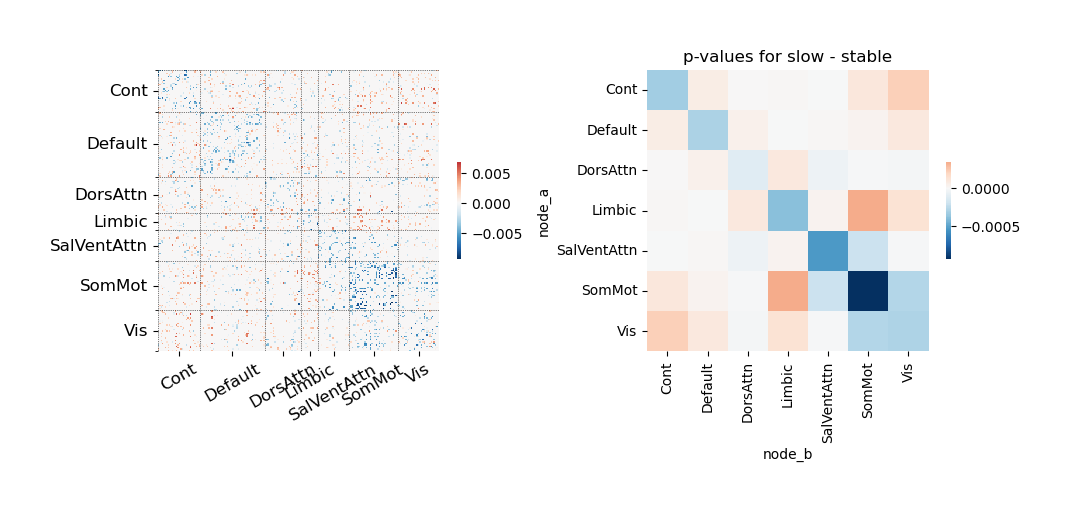

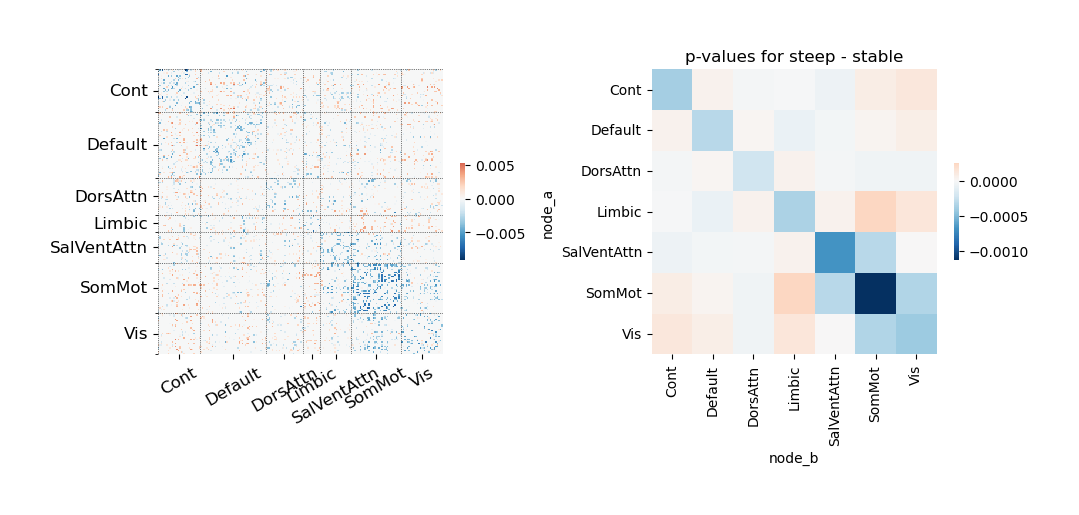

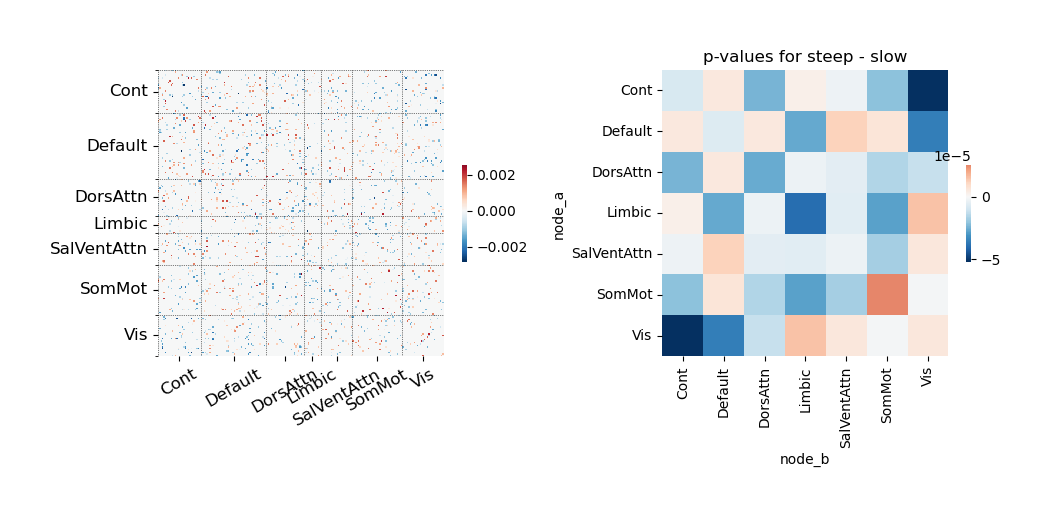

In [11]:
from neuroginius.matrices import MatrixResult
atlas = Atlas.from_name("schaefer200")

for class1, class2 in combinations(classes, 2):

    tmp_thresholded_mat = p_values[class2, class1]
    # tmp_thresholded_mat = corrected_p_values[class2, class1]
    tmp_ambient_mat = ambient_diff_matrices[class2, class1]
    # tmp_thresholded_mat = np.where(tmp_thresholded_mat < 0.05, tmp_thresholded_mat, 0)
    tmp_thresholded_mat = np.where(tmp_thresholded_mat < 0.05, tmp_ambient_mat, 0)
    # tmp_thresholded_mat = -np.log(tmp_thresholded_mat)
    # plot_matrix(tmp_thresholded_mat, atlas, cmap='RdBu_r', vmin=0, vmax=1)
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 10))
    sns.heatmap(MatrixResult(tmp_thresholded_mat, atlas=atlas).sorted_matrix, square=True, 
                center=0,
                cmap='RdBu_r', ax=ax1, cbar_kws={'shrink': 0.1})
    set_network_ticks(ax1, atlas)
    sns.heatmap(MatrixResult(tmp_thresholded_mat, atlas=atlas).get_macro_matrix(), square=True, 
                center=0,
                cmap='RdBu_r', ax=ax2, cbar_kws={'shrink': 0.1})
    # set_network_ticks(ax1, atlas)
    plt.title(f"p-values for {class2} - {class1}")
    plt.tight_layout()



In [12]:
def multivariate_blocks(block):
    return (block,)

Calculating combined p-values for classes: slow - stable
Calculating combined p-values for classes: steep - stable
Calculating combined p-values for classes: steep - slow


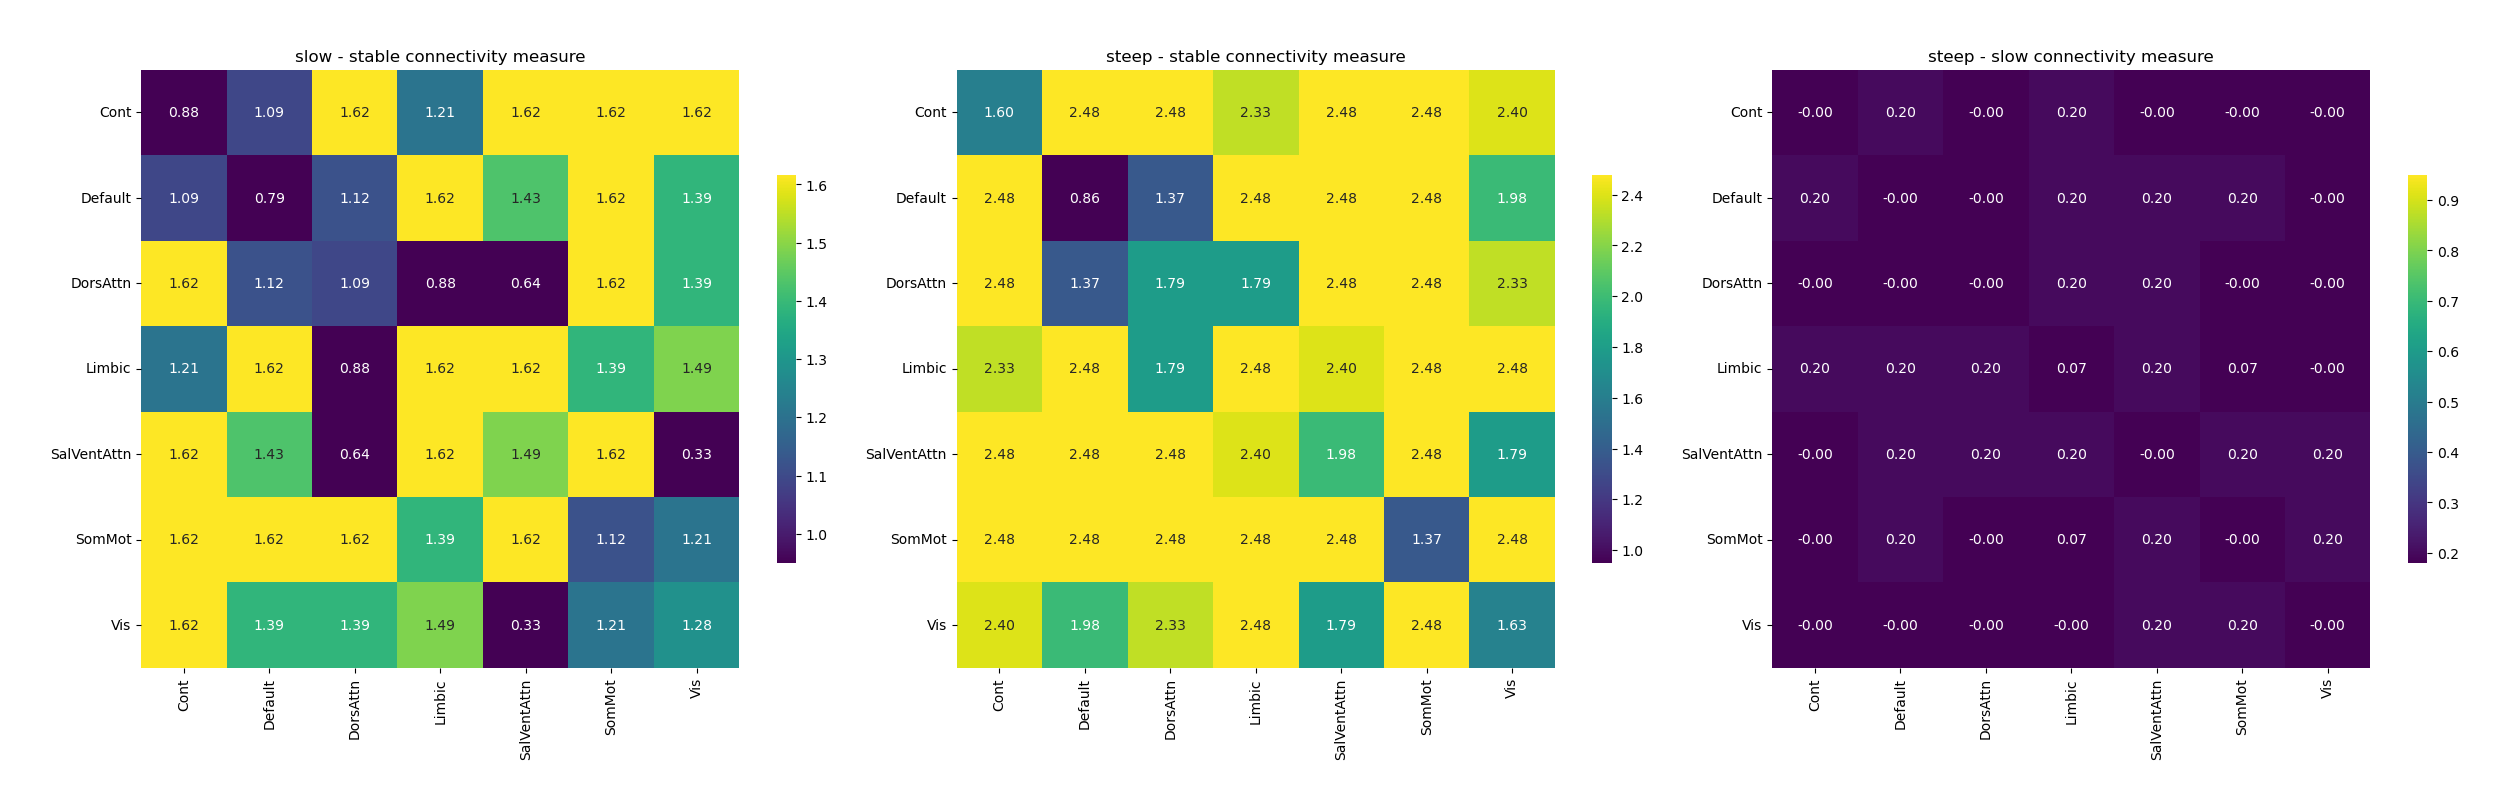

In [14]:
import numpy as np
from pycct import cct
from scipy.stats import combine_pvalues
from itertools import combinations_with_replacement
from statsmodels.stats.multitest import multipletests, fdrcorrection
fig, axs = plt.subplots(1, 3, figsize=(25, 10))
axs = axs.flatten()
for i, (class1, class2) in enumerate(combinations(classes, 2)):
    print(f"Calculating combined p-values for classes: {class2} - {class1}")

    tmp_pvalues = p_values[class2, class1].copy()

    RSNs = np.unique(atlas.macro_labels)
    blocks = list(combinations_with_replacement(RSNs, 2))

    blocked_patterns = MatrixResult(tmp_pvalues, atlas).get_macro_matrix(agg_func=multivariate_blocks)

    results = pd.DataFrame(index=RSNs, columns=RSNs, dtype=float)
    tmp_results = []
    for block_a, block_b in blocks:

        # Example with equal weights
        pvalues = blocked_patterns.loc[block_a, block_b].copy().ravel()

        result = cct(pvalues)
        # result = combine_pvalues(pvalues, method='mudholkar_george').pvalue
        tmp_results.append(result)

    # correction for multiple comparisons
    result_cor = multipletests(tmp_results, method='fdr_bh')[1]
    # print(f"Combined p-value: {result}")
    for block_idx, (block_a, block_b) in enumerate(blocks):
        results.loc[block_a, block_b] = result_cor[block_idx]
        results.loc[block_b, block_a] = result_cor[block_idx]

    sns.heatmap(-np.log(results), cmap='viridis', annot=True, fmt=".2f", square=True, vmin=0.95,
                ax=axs[i], cbar_kws={'shrink': 0.4})
    # plt.title(f"{class2} - {class1} connectivity measure")
    axs[i].set_title(f"{class2} - {class1} connectivity measure")

plt.tight_layout()
plt.show()

In [15]:
cat_diff_matrices = []
for key in diff_matrices.keys():
    tmp_diff_mat = diff_matrices[key]
    tmp_pvalues = corrected_p_values[key]
    tmp_diff_mat = np.where(tmp_pvalues < 0.05, tmp_diff_mat, 0)
    cat_diff_matrices.append(tmp_diff_mat[np.triu_indices(200, k=1)].ravel())
cat_diff_matrices = np.array(cat_diff_matrices).T

(19900,)
(19900,)
(19900,)
[NiftiLabelsMasker.inverse_transform] computing image from signals
[NiftiLabelsMasker.inverse_transform] computing image from signals
[NiftiLabelsMasker.inverse_transform] computing image from signals


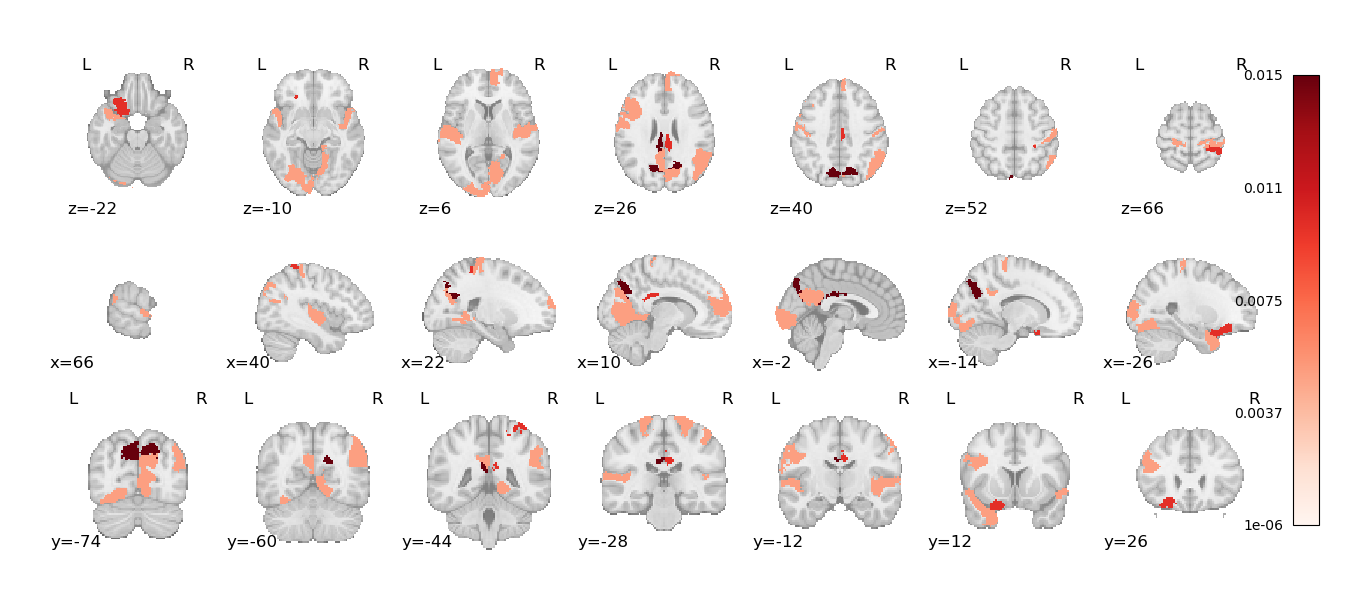

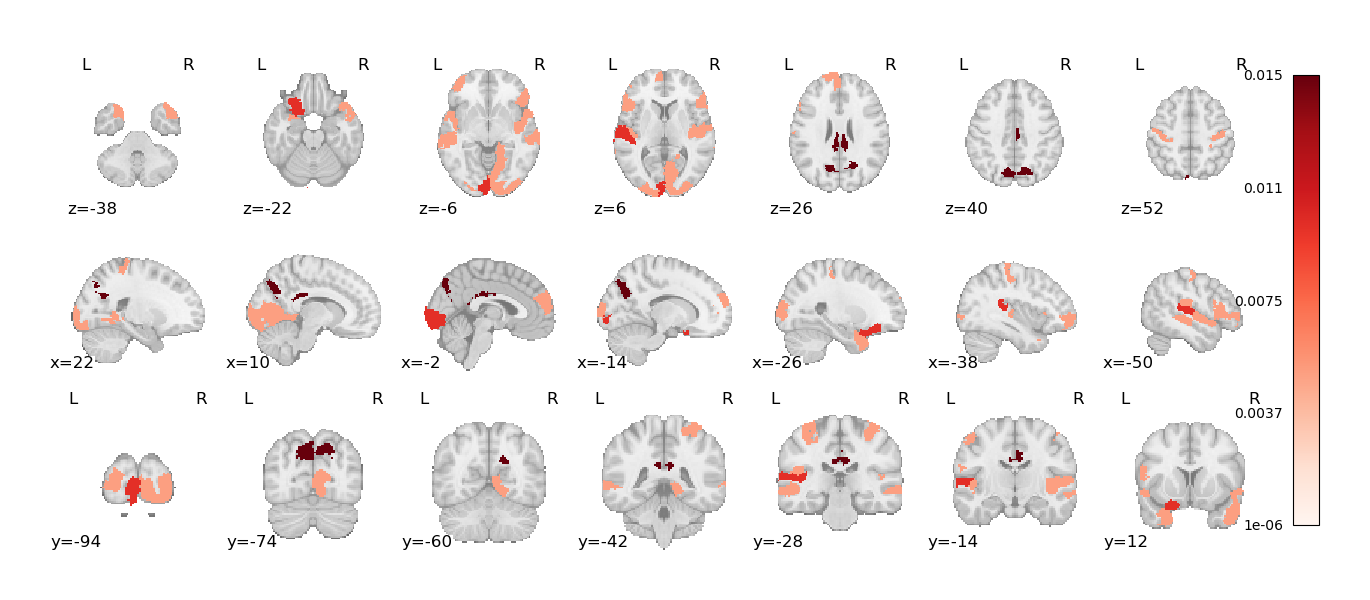

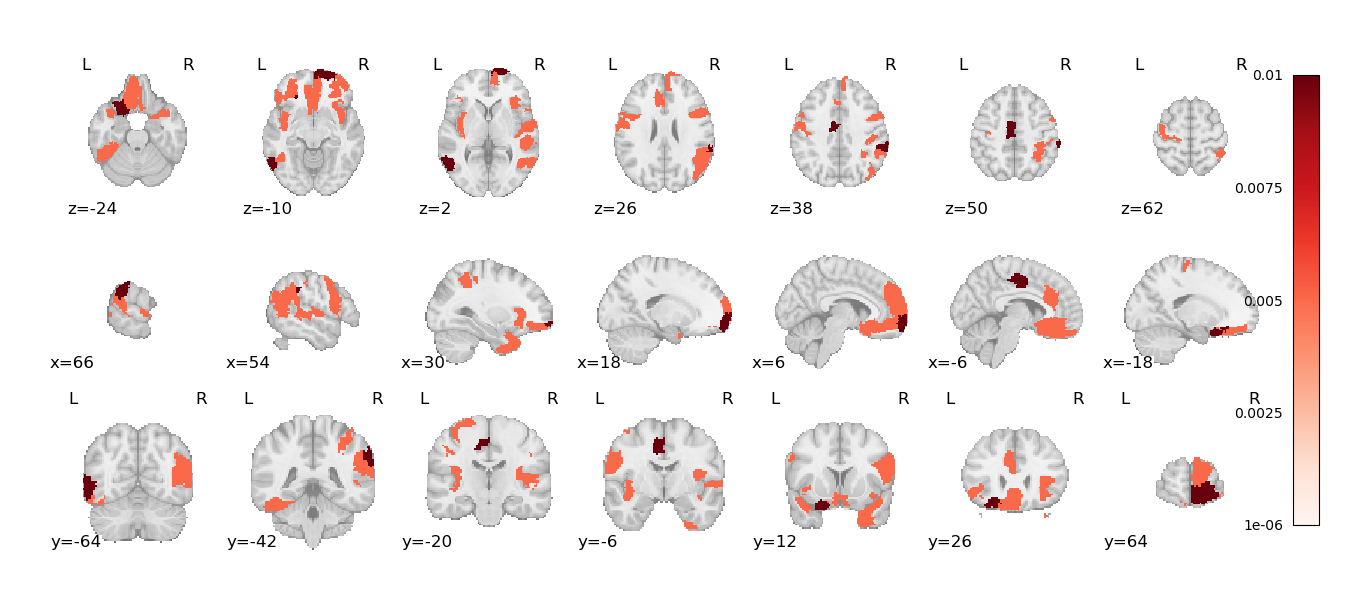

In [23]:
from nilearn.image import concat_imgs

classes_combinations = list(combinations(classes, 2))
percentile_masks = []
for tmp_mat in cat_diff_matrices.T:
    print(tmp_mat.shape)
    neg_mat = np.where(tmp_mat < 0, tmp_mat, 0)
    threshold = np.percentile(np.abs(tmp_mat), 99.9)
    mask = np.where(np.abs(tmp_mat) > threshold, 1, 0)
    percentile_masks.append(mask)
percentile_masks = np.array(percentile_masks).T


maps = []
for i in range(percentile_masks.shape[1]):
    tmp_combination = classes_combinations[i]
    class1, class2 = tmp_combination
    tmp_pippo = squareform(percentile_masks[:,i]).mean(axis=0)

    tmp_projected_pippo = masker.inverse_transform(tmp_pippo)

    from nilearn.plotting import plot_stat_map
    plot_stat_map(tmp_projected_pippo, display_mode='mosaic', cmap='Reds')
    tmp_projected_pippo.to_filename(f"tmp_mask_{class2}_{class1}.nii.gz")
    maps.append(tmp_projected_pippo)
concat_imgs(maps).to_filename(f"tmp_masks.nii.gz")

In [29]:
def extract_anatomical_label(label):
    region_tags = str(label).split("_")
    if len(region_tags) == 4:
        return region_tags[2]
    return region_tags[3]


anatomical_labels = tuple(map(extract_anatomical_label, atlas.labels))
anatomical_labels

('Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'SomMot',
 'Post',
 'Post',
 'Post',
 'Post',
 'Post',
 'Post',
 'Post',
 'Post',
 'Post',
 'Post',
 'FEF',
 'FEF',
 'PrCv',
 'ParOper',
 'ParOper',
 'ParOper',
 'FrOperIns',
 'FrOperIns',
 'FrOperIns',
 'FrOperIns',
 'PFCl',
 'Med',
 'Med',
 'Med',
 'OFC',
 'OFC',
 'TempPole',
 'TempPole',
 'TempPole',
 'TempPole',
 'Par',
 'Par',
 'Par',
 'Temp',
 'OFC',
 'PFCl',
 'PFCl',
 'PFCl',
 'PFCl',
 'PFCl',
 'pCun',
 'Cing',
 'Cing',
 'Temp',
 'Temp',
 'Temp',
 'Temp',
 'Temp',
 'Par',
 'Par',
 'Par',
 'Par',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'PFC',
 'pCunPCC',
 'pCunPCC',
 'pCunPCC',
 'pCunPCC',
 'PHC',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis',
 'Vis'

In [30]:
unique_labels = np.unique(anatomical_labels)
mapping = {unique_labels[i]: i for i in range(len(unique_labels))}
anatomical_labels_int = pd.Series(anatomical_labels).map(mapping).values

[NiftiLabelsMasker.inverse_transform] computing image from signals


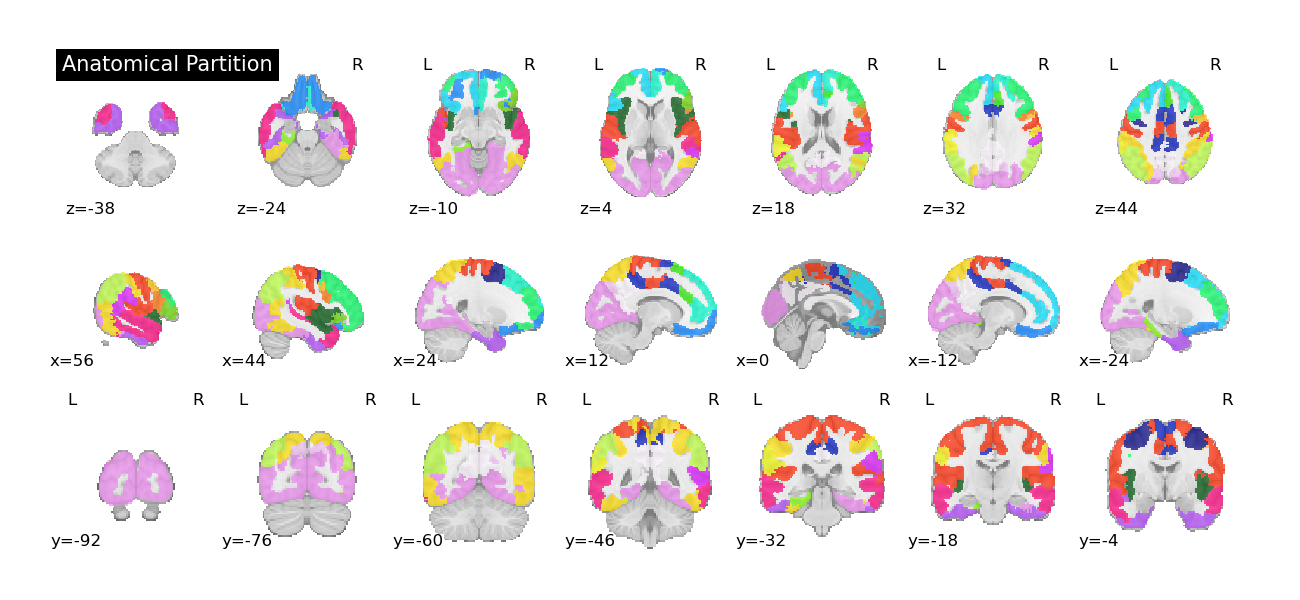

In [31]:
anatomical_atlas_map = masker.inverse_transform(anatomical_labels_int.astype(np.int32))

from nilearn.plotting import plot_roi
plot_roi(anatomical_atlas_map, title="Anatomical Partition", display_mode='mosaic')

In [32]:
class NiftiImageAtlas:
    def __init__(self, nifti_image, macro_labels=None):
        self.nifti_image = nifti_image
        self.labels = np.unique(nifti_image.get_fdata())
        if macro_labels is not None:
            self.macro_labels = macro_labels
        else:
            self.macro_labels = np.unique(self.labels)
        self.maps = nifti_image

    @classmethod
    def from_path(cls, path):
        from nilearn.image import load_img
        return cls(load_img(path))
    
anatomical_atlas = NiftiImageAtlas(anatomical_atlas_map, macro_labels=anatomical_labels)

In [34]:
def to_matrix(vec):
    n = int(np.sqrt(len(vec) * 2))
    mat = np.zeros((n, n))
    mat[np.triu_indices(n, k=0)] = vec
    mat += mat.T
    np.fill_diagonal(mat, np.diag(mat) / 2)
    return mat

def binarize(matrix):
    pos_matrix = np.zeros_like(matrix)
    neg_matrix = np.zeros_like(matrix)

    pos_matrix[matrix > 0] = 1
    neg_matrix[matrix < 0] = 1
    return pos_matrix, neg_matrix

def degree_centrality(matrix):
    pos_matrix, neg_matrix = binarize(matrix)
    pos_degree = pos_matrix.sum(axis=0)
    neg_degree = neg_matrix.sum(axis=0)
    return pos_degree, neg_degree

Calculating combined p-values for classes: slow - stable
[NiftiLabelsMasker.inverse_transform] computing image from signals
[NiftiLabelsMasker.inverse_transform] computing image from signals
Calculating combined p-values for classes: steep - stable
[NiftiLabelsMasker.inverse_transform] computing image from signals
[NiftiLabelsMasker.inverse_transform] computing image from signals
Calculating combined p-values for classes: steep - slow
[NiftiLabelsMasker.inverse_transform] computing image from signals
[NiftiLabelsMasker.inverse_transform] computing image from signals


/tmp/ipykernel_77030/4205623895.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


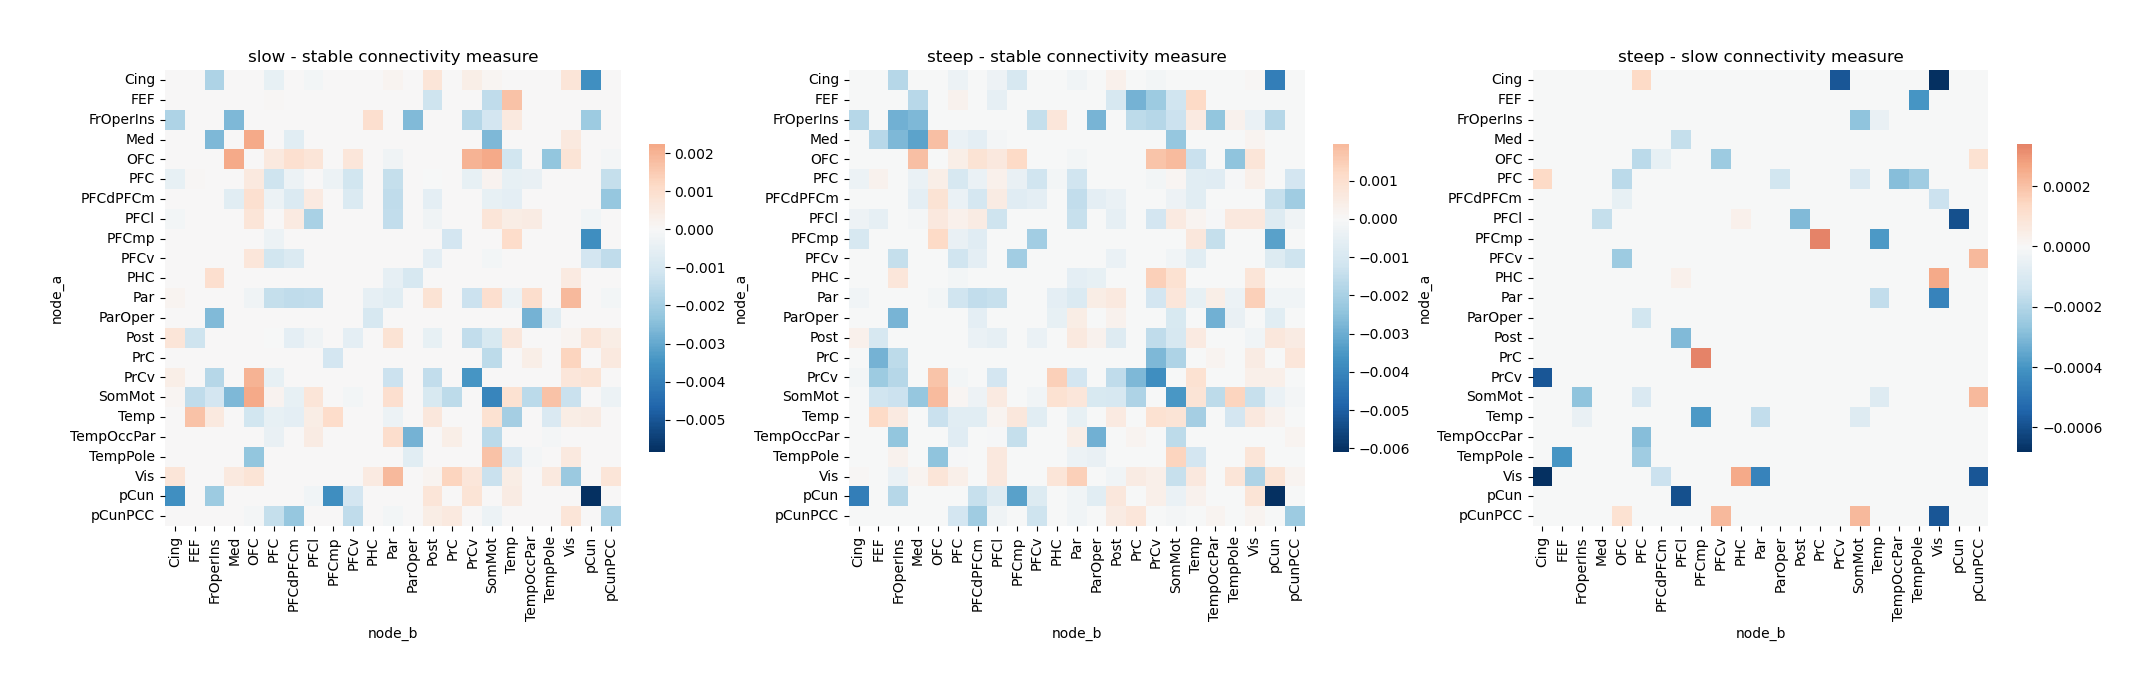

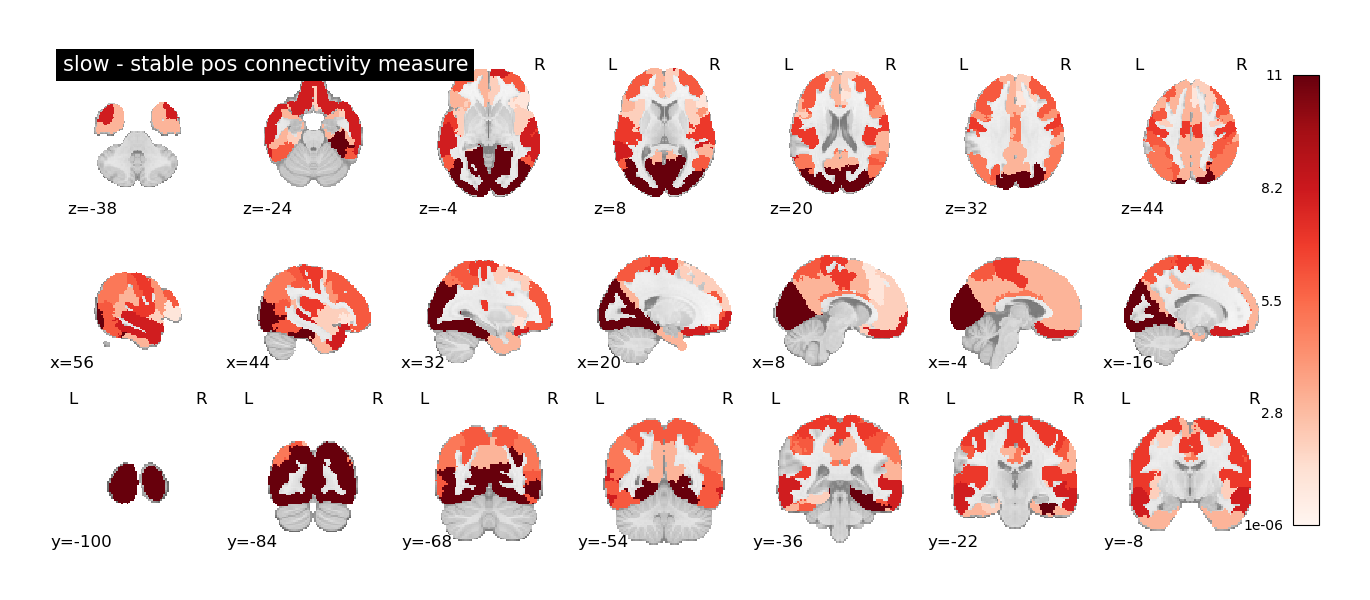

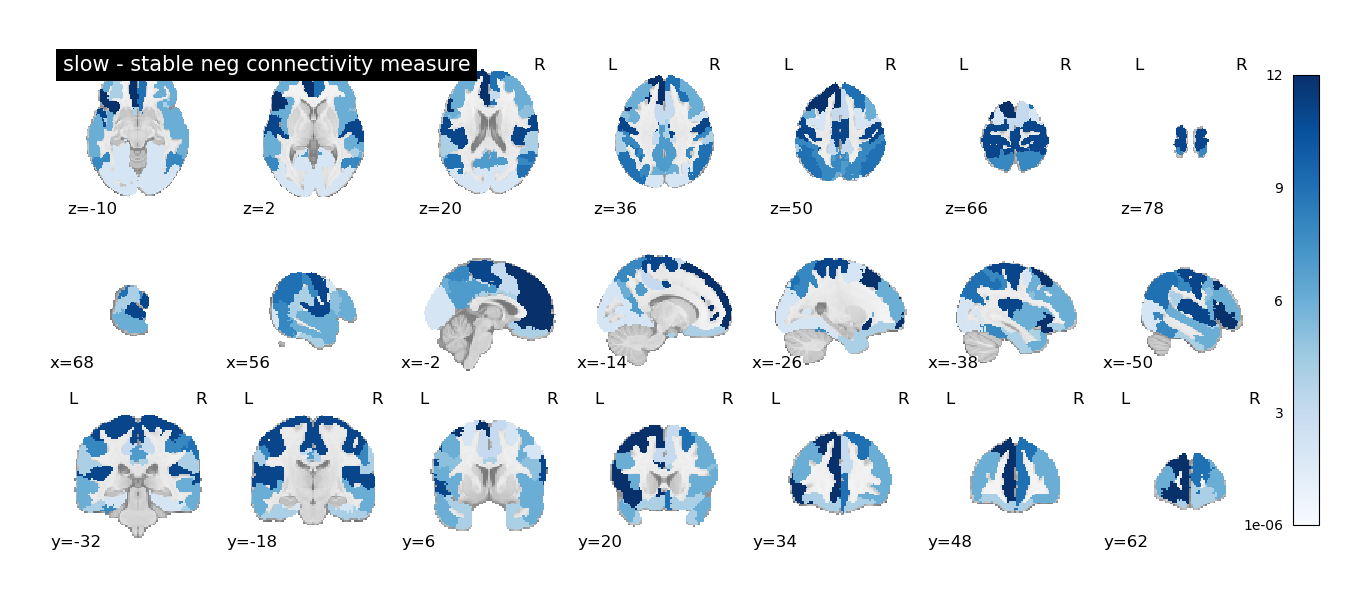

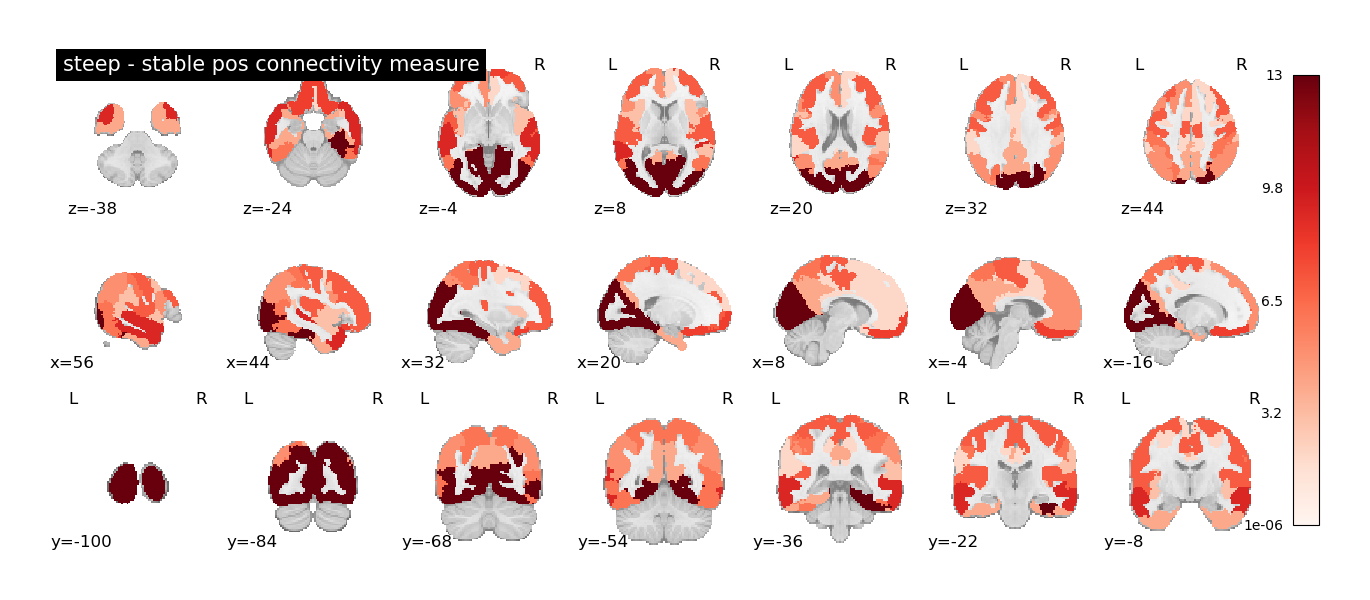

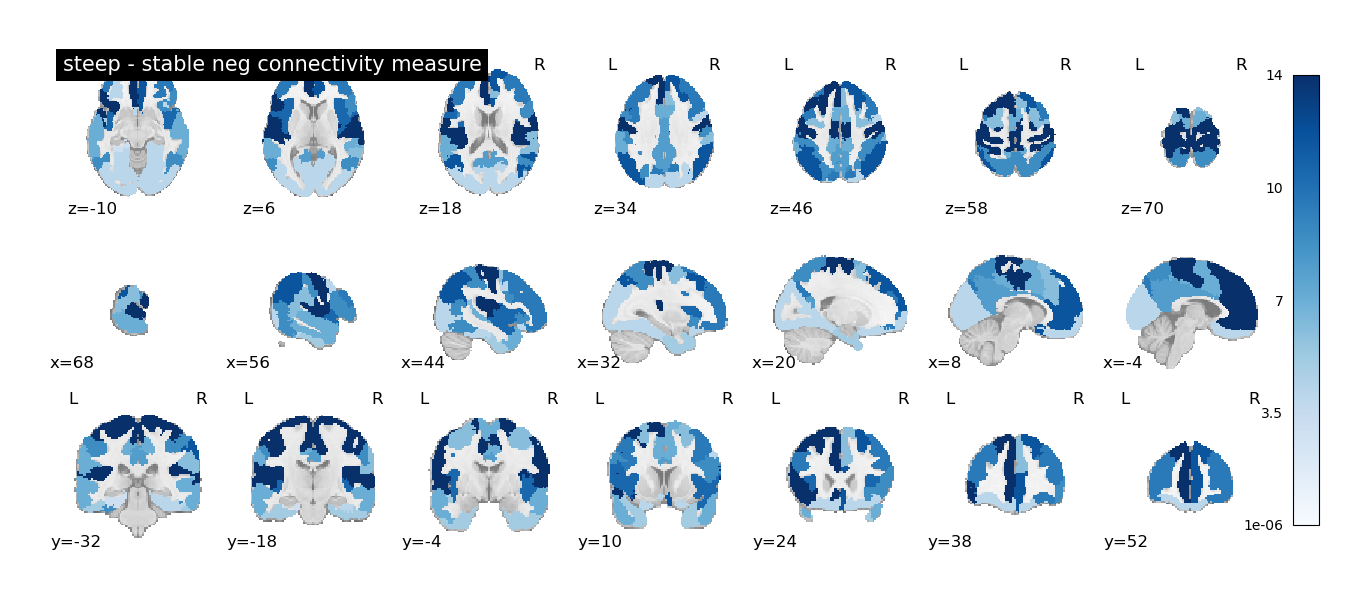

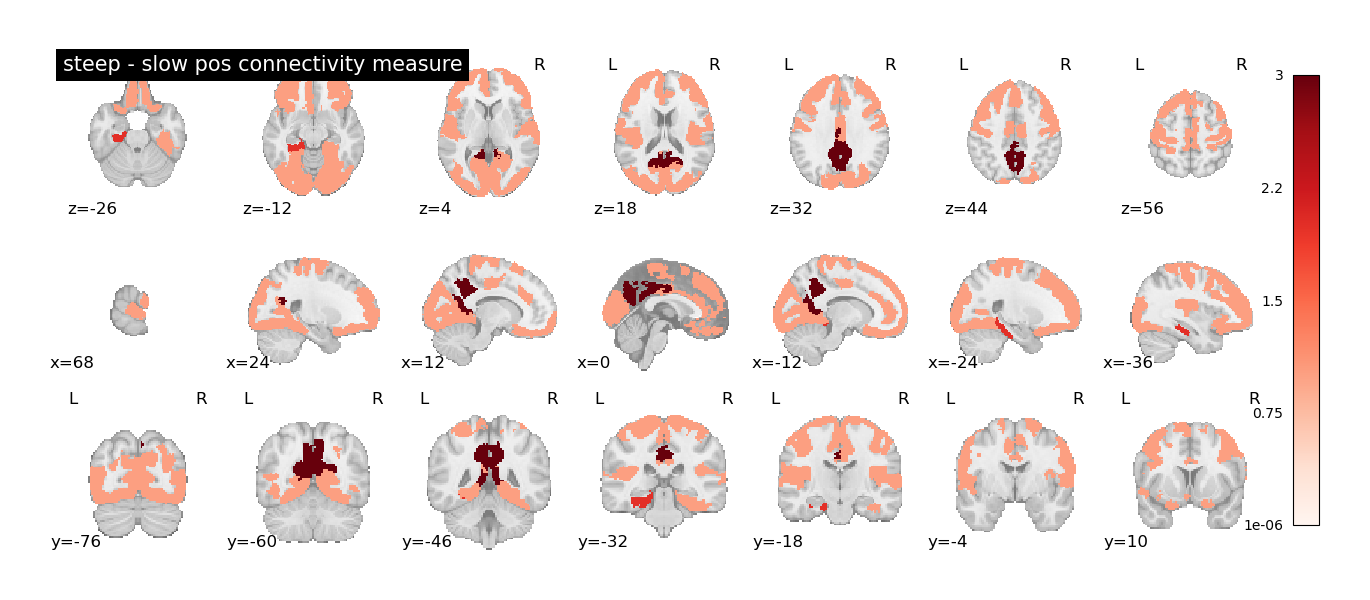

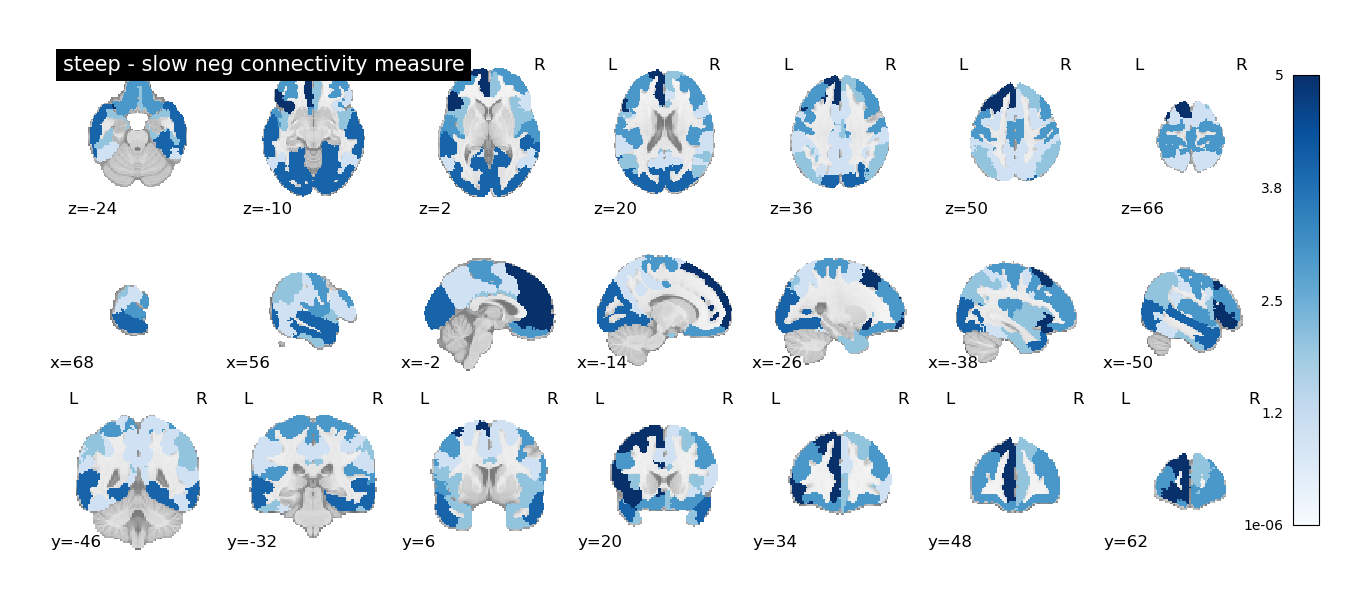

In [35]:
import numpy as np
from pycct import cct
from scipy.stats import combine_pvalues
from itertools import combinations_with_replacement
from statsmodels.stats.multitest import multipletests, fdrcorrection
from nilearn.connectome import vec_to_sym_matrix

results_vecs = []
fig, axs = plt.subplots(1, 3, figsize=(25, 10))
axs = axs.flatten()

for i, (class1, class2) in enumerate(combinations(classes, 2)):
    print(f"Calculating combined p-values for classes: {class2} - {class1}")

    tmp_pvalues = p_values[class2, class1].copy()
    tmp_ambient_mat = ambient_diff_matrices[class2, class1]

    anatomical_networks = np.unique(anatomical_labels)
    blocks = list(combinations_with_replacement(anatomical_networks, 2))

    blocked_patterns = MatrixResult(tmp_pvalues, anatomical_atlas).get_macro_matrix(agg_func=multivariate_blocks)

    results = pd.DataFrame(index=anatomical_networks, columns=anatomical_networks, dtype=float)
    tmp_results = []
    tmp_stats = []
    for block_a, block_b in blocks:

        pvalues = blocked_patterns.loc[block_a, block_b].copy().ravel()

        # result = cct(pvalues)
        result = combine_pvalues(pvalues, method='fisher')
        pvalue = result.pvalue
        stat = result.statistic
        tmp_results.append(pvalue < 0.05)
        tmp_stats.append(stat)

    # correction for multiple comparisons
    result_cor = multipletests(tmp_results, method='fdr_bh')[1]
    # result_cor = tmp_results.copy()
    # print(f"Combined p-value: {result}")
    for block_idx, (block_a, block_b) in enumerate(blocks):
        results.loc[block_a, block_b] = result_cor[block_idx]
        results.loc[block_b, block_a] = result_cor[block_idx]
    
    significance_mask = to_matrix(np.array(tmp_results)).astype(bool)
    
    tmp_ambient_mat_thresholded = np.where(tmp_pvalues, tmp_ambient_mat, 0)
    block_thresholded_differences = MatrixResult(tmp_ambient_mat_thresholded, atlas=anatomical_atlas).get_macro_matrix(lambda block: (block.sum() / np.count_nonzero(block),))
    block_thresholded_differences = block_thresholded_differences.where(significance_mask, 0)

    pos_centrality, neg_centrality = degree_centrality(block_thresholded_differences)
    pos_results_vec = np.zeros(len(anatomical_labels))
    neg_results_vec = np.zeros(len(anatomical_labels))
    for idx, label in enumerate(anatomical_labels_int):
        pos_results_vec[idx] = pos_centrality[label]
        neg_results_vec[idx] = neg_centrality[label]

    # sns.heatmap(results, cmap='seismic', annot=False, fmt=".2f", square=True,
    #             ax=axs[i], cbar_kws={'shrink': 0.4})
    sns.heatmap(block_thresholded_differences, center=0, cmap='RdBu_r', ax=axs[i],
                square=True,
                cbar_kws={'shrink': 0.4}, annot=False)

    axs[i].set_title(f"{class2} - {class1} connectivity measure")

    pos_projected_results = masker.inverse_transform(pos_results_vec)
    neg_projected_results = masker.inverse_transform(neg_results_vec)
    plot_stat_map(pos_projected_results, display_mode='mosaic', cmap='Reds', title=f"{class2} - {class1} pos connectivity measure", symmetric_cbar=False)
    plot_stat_map(neg_projected_results, display_mode='mosaic', cmap='Blues', title=f"{class2} - {class1} neg connectivity measure", symmetric_cbar=False)
    # projected_results.to_filename(f"tmp_mescmask_{class2}_{class1}.nii.gz")
plt.tight_layout()
plt.show()